<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/2%20Aprendizaje%20profundo%20(I)/Sesion%202/6_autoencoders_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrenamiento de Autoencoders con datos de dígitos (MNIST)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Lambda, Dropout
import matplotlib.pyplot as plt
tf.random.set_seed(42)

## Carga y procesamiento de los datos


In [2]:
# Carga
(X_train, y_train), (X_test, _) = tf.keras.datasets.mnist.load_data()
print(' -Entradas Entrenamiento:', X_train.shape)
print(' -Entradas Test:', X_test.shape)

# Normalización
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print('Cambio de dimensiones para ajustar a la entrada de un Perceptrón:')
x_shape = X_train.shape
X_train = X_train.reshape(x_shape[0], x_shape[1]*x_shape[2])
X_test = X_test.reshape(len(X_test), x_shape[1]*x_shape[2])
print(' -Entradas Entrenamiento:', X_train.shape)
print(' -Entradas Test:', X_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
 -Entradas Entrenamiento: (60000, 28, 28)
 -Entradas Test: (10000, 28, 28)
Cambio de dimensiones para ajustar a la entrada de un Perceptrón:
 -Entradas Entrenamiento: (60000, 784)
 -Entradas Test: (10000, 784)


**Comentario sobre usar Crossentropy como medida del error** (y - f(x))

In [3]:
# El problema de la entropía cruzada es que es asimétrica respecto al valor medido (los dos resultados podrían ser iguales ya que significan
# lo misma  nivel de error, pero no lo son)
tf.losses.binary_crossentropy(np.array([.8]), np.array([.9]))

<tf.Tensor: shape=(), dtype=float64, numpy=0.5448051422362862>

In [4]:
tf.losses.binary_crossentropy(np.array([.8]), np.array([.7]))

<tf.Tensor: shape=(), dtype=float64, numpy=0.5261343350638115>

In [5]:
#Por otro lado, la entropía cruzada tiene un sesgo hacia el 0.5.
# Pasar de 0.3 a 0.4 tiene un error menor que pasar de 0.3 a 0.2 (al contrario que si esta situación se diera por encima de 0.5, 
# como en el caso de arriba)
tf.losses.binary_crossentropy(np.array([.3]), np.array([.4]))

<tf.Tensor: shape=(), dtype=float64, numpy=0.6324649645317925>

In [6]:
tf.losses.binary_crossentropy(np.array([.3]), np.array([.2]))

<tf.Tensor: shape=(), dtype=float64, numpy=0.6390316221502198>

In [7]:
#Es decir, se suele tender mucho al 0.5 con el crossentropy, salen resultados más 'sucios' (este adjetivo me lo he inventado yo, no recuerdo
# qué ha dicho el profe en concreto)

## Autoencoder profundo
### Creación del autoencoder
Vamos a crear un autoencoder que codifique y decodifique la entrada de 728 píxeles en la siguiente secuencia de dimensiones:

784 → 128 → 64 → 32 → 64 → 128 → 784

In [8]:
# Tamaño de nuestra representación codificada
encoding_dim = 32  # Factor de compresión = 24.5 (dado que la entrada es de tamaño 784)

# Definimos las capas para la entrada, el encoder y el decoder:
# Capa de entrada
input_img = Input(shape=(784,), name='Input')

# Capas del encoder
encoder1 = Dense(128, activation='relu', name='Encoder1')
encoder2 = Dense(64, activation='relu', name='Encoder2')
encoder3 = Dense(32, activation='relu', name='Encoder3')

# Capas del decoder
decoder1 = Dense(64, activation='relu', name='Decoder1')
decoder2 = Dense(128, activation='relu', name='Decoder2')
decoder3 = Dense(784, activation='sigmoid', name='Decoder3')

#       Autoencoder
# --------------------------
# "encoded" es la representación codificada de la entrada (cada vez más comprimida)
encoded = encoder1(input_img)
encoded = encoder2(encoded)
encoded = encoder3(encoded)

# "decoded" es la reconstrución de la entrada a partir de la entrada codificada
decoded = decoder1(encoded)
decoded = decoder2(decoded)
decoded = decoder3(decoded)


# Modelo que reconstruye una entrada
autoencoder = tf.keras.Model(input_img, decoded)

# Visualizar arquitectura y dimensiones
print(f"{'*'*65}\n\t\t\tAutoencoder\n{'*'*65}")
autoencoder.summary()

*****************************************************************
			Autoencoder
*****************************************************************
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
Encoder1 (Dense)             (None, 128)               100480    
_________________________________________________________________
Encoder2 (Dense)             (None, 64)                8256      
_________________________________________________________________
Encoder3 (Dense)             (None, 32)                2080      
_________________________________________________________________
Decoder1 (Dense)             (None, 64)                2112      
_________________________________________________________________
Decoder2 (Dense)             (None, 128

### Entrenamiento

In [9]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['MeanSquaredError'])
hist= autoencoder.fit(x=X_train, 
                      y=X_train,
                      epochs=50,
                      batch_size=256,
                      shuffle=True,
                      validation_data=(X_test, X_test))

Epoch 1/50
235/235 [==============================] - 1s 4ms/step - loss: 0.2454 - mean_squared_error: 0.0609 - val_loss: 0.1664 - val_mean_squared_error: 0.0348
Epoch 2/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1488 - mean_squared_error: 0.0287 - val_loss: 0.1340 - val_mean_squared_error: 0.0237
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1284 - mean_squared_error: 0.0218 - val_loss: 0.1215 - val_mean_squared_error: 0.0196
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1194 - mean_squared_error: 0.0188 - val_loss: 0.1157 - val_mean_squared_error: 0.0177
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1149 - mean_squared_error: 0.0173 - val_loss: 0.1116 - val_mean_squared_error: 0.0163
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1114 - mean_squared_error: 0.0162 - val_loss: 0.1083 - val_mean_squared_error: 0.0153
Epoch 7/50
235/235 [========

### Evaluación y visualización

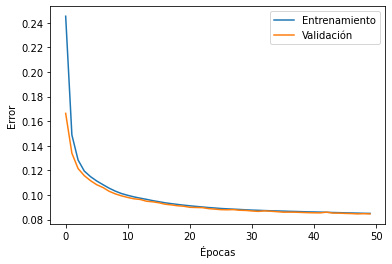

In [10]:
plt.figure()
plt.xlabel('Épocas')
plt.ylabel('Error')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Entrenamiento', 'Validación']);

Hacemos diferentes pruebas para encontrar un model mejor que el dado por el profesor

In [ ]:
#HACEMOS DIFERENTES PRUEBAS PARA ENCONTRAR UN MODELO MEJOR

# Tamaño de nuestra representación codificada
encoding_dim = 32  # Factor de compresión = 24.5 (dado que la entrada es de tamaño 784)

# Definimos las capas para la entrada, el encoder y el decoder:
# Capa de entrada
input_img = Input(shape=(784,), name='Input')

# Capas del encoder
encoder1 = Dense(256, activation='relu', name='Encoder1')
#drop1 = Dropout(0.5, name='Dropout1')
encoder3 = Dense(32, activation='relu', name='Encoder3')

# Capas del decoder
decoder1 = Dense(256, activation='relu', name='Decoder1')
#drop3 = Dropout(0.5, name='Dropout3')
decoder3 = Dense(784, activation='sigmoid', name='Decoder3')

#       Autoencoder
# --------------------------
# "encoded" es la representación codificada de la entrada (cada vez más comprimida)
encoded = encoder1(input_img)
#encoded = drop1(encoded)
encoded = encoder3(encoded)

# "decoded" es la reconstrución de la entrada a partir de la entrada codificada
decoded = decoder1(encoded)
#encoded = drop3(decoded)
decoded = decoder3(decoded)


# Modelo que reconstruye una entrada
autoencoder = tf.keras.Model(input_img, decoded)

# Visualizar arquitectura y dimensiones
print(f"{'*'*65}\n\t\t\tAutoencoder\n{'*'*65}")
autoencoder.summary()

*****************************************************************
			Autoencoder
*****************************************************************
Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
Encoder1 (Dense)             (None, 256)               200960    
_________________________________________________________________
Encoder3 (Dense)             (None, 32)                8224      
_________________________________________________________________
Decoder1 (Dense)             (None, 256)               8448      
_________________________________________________________________
Decoder3 (Dense)             (None, 784)               201488    
Total params: 419,120
Trainable params: 419,120
Non-trainable params: 0
________________________________

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['MeanSquaredError'])
hist= autoencoder.fit(x=X_train, 
                      y=X_train,
                      epochs=50,
                      batch_size=256,
                      shuffle=True,
                      validation_data=(X_test, X_test))

Epoch 1/50
235/235 [==============================] - 1s 4ms/step - loss: 0.2075 - mean_squared_error: 0.0475 - val_loss: 0.1298 - val_mean_squared_error: 0.0221
Epoch 2/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1172 - mean_squared_error: 0.0179 - val_loss: 0.1075 - val_mean_squared_error: 0.0149
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1049 - mean_squared_error: 0.0140 - val_loss: 0.0999 - val_mean_squared_error: 0.0124
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0992 - mean_squared_error: 0.0121 - val_loss: 0.0963 - val_mean_squared_error: 0.0113
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0964 - mean_squared_error: 0.0112 - val_loss: 0.0941 - val_mean_squared_error: 0.0106
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0944 - mean_squared_error: 0.0106 - val_loss: 0.0927 - val_mean_squared_error: 0.0101
Epoch 7/50
235/235 [========

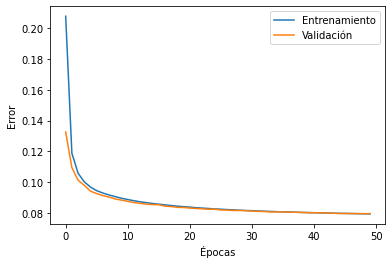

In [ ]:
plt.figure()
plt.xlabel('Épocas')
plt.ylabel('Error')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Entrenamiento', 'Validación']);


*****************************************************************
			Encoder
*****************************************************************
Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
Encoder1 (Dense)             (None, 128)               100480    
_________________________________________________________________
Encoder2 (Dense)             (None, 64)                8256      
_________________________________________________________________
Encoder3 (Dense)             (None, 32)                2080      
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________


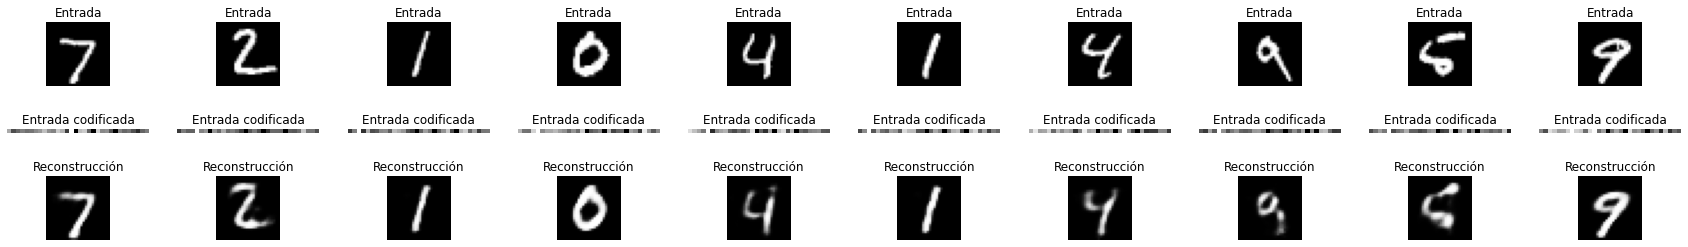

In [ ]:
# Vamos a crear ahora por un lado un modelo para el encoder y otro para el decoder
#          Encoder
# ------------------------

encoder = tf.keras.Model(input_img, encoded)

#AQUÍ FALLA ALGO DEL CÓDIGO

# Visualizar arquitectura y dimensiones
print(f"\n{'*'*65}\n\t\t\tEncoder\n{'*'*65}")
encoder.summary()

# Codificamos y decodificamos algunos dígitos de ejemplo (datos de test)
# -----------------------
encoded_imgs = encoder.predict(X_test)
decoded_imgs = autoencoder.predict(X_test)
 
n_images = 10 
plt.figure(figsize=(30, 4))
for i in range(n_images):
    # Entrada (original)
    plt.subplot(3, n_images, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title('Entrada')
    plt.axis('off')

    # Codificación
    plt.subplot(3, n_images, i + 1 + n_images)
    plt.imshow(encoded_imgs[i].reshape(1, encoding_dim), cmap='gray')
    plt.axis('off')
    plt.title('Entrada codificada')
    
    # Reconstrucción
    plt.subplot(3, n_images, i + 1 + n_images + n_images)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title('Reconstrucción')



## Aplicación: Eliminación de ruido
Para obtener un modelo capaz de eliminar ruido de las imágenes de dígitos vamos a entrenar un autoencoder que mapee imágenes de dígitos con ruido (entrada) a imágenes de dígitos "limpias".

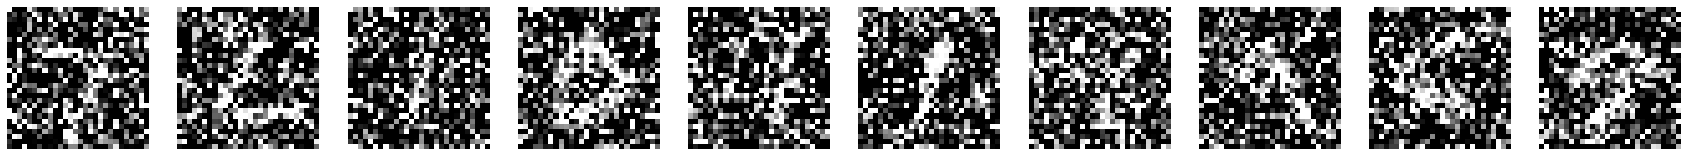

In [ ]:
# Añadimos ruido gaussiano (distribución normal) a las imágenes.
noise_factor = 0.8
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

# Aseguramos que todos los pixeles queden en el rango [0, 1]
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

# Dibujamos las imágenes con ruido
n_images = 10
plt.figure(figsize=(30, 3))
for i in range(n_images):
    plt.subplot(1, n_images, i+1)
    plt.imshow(X_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

### Creación del modelo y entrenamiento

In [ ]:
# Creación del modelo
encoding_dim = 32
autoencoder = tf.keras.models.Sequential()
autoencoder.add(Dense(128, activation='relu', input_shape=(784,)))
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(32, activation='relu'))
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(784, activation='sigmoid'))

# Entrenamiento
autoencoder.compile(optimizer='adam', loss='MeanSquaredError')
hist= autoencoder.fit(X_train_noisy, 
                      X_train,
                      epochs=50,
                      batch_size=256,
                      shuffle=True,
                      validation_data=(X_test_noisy, X_test))


Epoch 1/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0710 - val_loss: 0.0545
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0506 - val_loss: 0.0463
Epoch 3/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0435 - val_loss: 0.0410
Epoch 4/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0401 - val_loss: 0.0385
Epoch 5/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0380 - val_loss: 0.0368
Epoch 6/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0364 - val_loss: 0.0354
Epoch 7/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0350 - val_loss: 0.0342
Epoch 8/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0340 - val_loss: 0.0337
Epoch 9/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0332 - val_loss: 0.0329
Epoch 10/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0326 - val_loss: 0.0324

### Evaluación y visualización

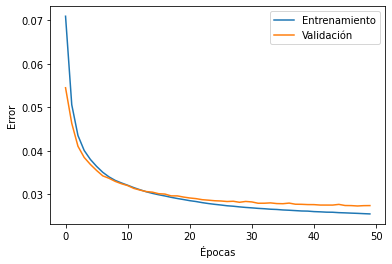

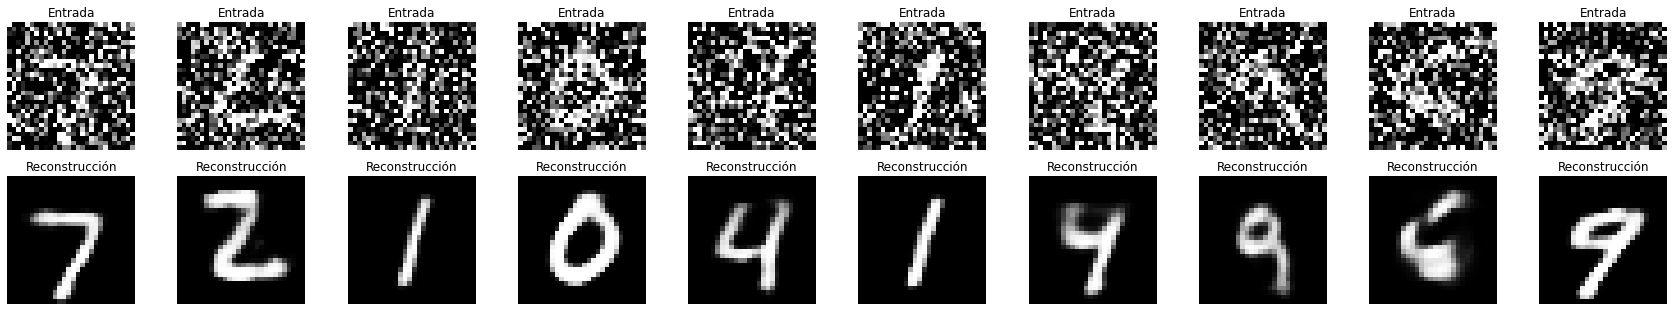

In [ ]:
plt.figure()
plt.xlabel('Épocas')
plt.ylabel('Error')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Entrenamiento', 'Validación'])

predictions = autoencoder.predict(X_test)
n_images = 10 
plt.figure(figsize=(30, 8))
for i in range(n_images):
    # Entrada (original)
    plt.subplot(3, n_images, i + 1)
    plt.imshow(X_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title('Entrada')
    plt.axis('off')
    
    # Reconstrucción
    plt.subplot(3, n_images, i + 1 + n_images)
    plt.imshow(predictions[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title('Reconstrucción')

## Autoencoder Variacional
### Creación del Encoder

In [11]:
class Encoder(tf.keras.Model):
  def __init__(self):
    super(Encoder, self).__init__()

    # Capas del encoder
    self.encoder1 = Dense(128, activation='relu', name='Encoder1')
    self.encoder2 = Dense(64, activation='relu', name='Encoder2')
    self.encoder3 = Dense(32, activation='relu', name='Encoder3')

  def call(self, inputs, training=None, mask=None):
    x = self.encoder1(inputs)
    x = self.encoder2(x)
    y = self.encoder3(x)

    return y

### Creación de la capa que representa la distribución normal

In [12]:
class NormalDistribution(tf.keras.Model):
  def __init__(self):
    super(NormalDistribution, self).__init__()
    
    # Capas
    self.z_mean = Dense(2, activation='linear', name='z_mean')
    self.z_log_var = Dense(2, activation='linear', name='z_log_var')

  def call(self, inputs, training=None, mask=None):
    z_mean = self.z_mean(inputs)
    z_log_var = self.z_log_var(inputs)
    
    return z_mean, z_log_var


### Creación de la capa de muestreo

In [20]:
class Reparametrize(tf.keras.layers.Layer):
  """
  Usa (z_mu, z_log_var) para muestrear z (el vector que 
  representa el dígito codificado)
  """
  def call(self, inputs):
    z_mu, z_log_var = inputs
    
    # Extraemos dimensiones (del batch y del espacio codificado)
    batch = tf.shape(z_mu)[0] #se puede usar cualquiera de las dos, z_mu o z_log_var, ya que tienen el mismo tamaño
    dim = tf.shape(z_mu)[1]
    
    # Muestreamos de una distribucion normal ϵ: con dimensiones (batch, dim_espacio_codificado)
    epsilon = tf.random.normal(shape=[batch, dim])
    
    # Transformamos log(σ^2) en σ 
    sigma = tf.exp(0.5 * z_log_var)

    # Truco de re-parametrización
    reparametrization = z_mu + sigma * epsilon
    
    return reparametrization


### Creación del Decoder

In [14]:
class Decoder(tf.keras.Model):
  def __init__(self):
    super(Decoder, self).__init__()

    # Capas del decoder
    self.decoder1 = Dense(64, activation='relu', name='Decoder1')
    self.decoder2 = Dense(128, activation='relu', name='Decoder2')
    self.decoder3 = Dense(784, activation='sigmoid', name='Decoder3')

  def call(self, inputs,  training=None, mask=None):
    x = self.decoder1(inputs)
    x = self.decoder2(x)
    y = self.decoder3(x)

    return y

### Creación de la función de coste

In [17]:
class LossVAE(tf.keras.layers.Layer):
  """
  Función de error custom: suma del término de reconstrucción y 
  el término de regularización KL divergence
  """
  def call(self, inputs):
    y_true, y_pred, z_mean, z_log_var = inputs
    
    # Error de reconstrucción (usa categorical_crossentropy)
    reconstruction_loss = tf.reduce_mean(tf.losses.binary_crossentropy(y_true, y_pred))
    reconstruction_loss *= 784 #lo multiplicamos por las dimensiones de la imagen porque al calcular binary_cossentropy sobre la imagen se calcula también la media.
    
    # Divergencia KL
    kl_loss = tf.square(z_mean) -1 - z_log_var + tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(0.5 * tf.reduce_sum(kl_loss, axis=-1))
  
    return reconstruction_loss + kl_loss

### Creación del Autoencoder Variacional

In [24]:
class VAE(tf.keras.Model):
    def __init__(self):
      super(VAE, self).__init__()
      # Capas del VAE
      self.encoder = Encoder()
      self.normal_distribution = NormalDistribution()
      self.reparametrize = Reparametrize()
      self.decoder = Decoder()
      self.vae_loss = LossVAE()


    def call(self, inputs,  training=None, mask=None):
      inputs = self.encoder(inputs)
      # inputs = self.encoder.call(inputs)  # Esta línea de código y la anterior son EQUIVALENTES en Python
      z_mean, z_log_var = self.normal_distribution(inputs)
      z = self.reparametrize([z_mean, z_log_var])
      decoded = self.decoder(z)
      return (z_mean, z_log_var, z), decoded

    def train_step(self, data):
      with tf.GradientTape() as tape:
        # Propagación hacia delante
        (z_mean, z_log_var, _), reconstruction = self.call(data)
        total_loss = self.vae_loss([data, reconstruction, z_mean, z_log_var])
      
      # Retro-propagación
      grads = tape.gradient(total_loss, self.trainable_weights)
      
      # Actualización de los pesos
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      
      return {"total_loss": total_loss}

### Entrenamiento del Autoencoder Variacional

In [25]:
vae = VAE()
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(X_train, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 2s 3ms/step - total_loss: 208.6183
Epoch 2/30
469/469 [==============================] - 2s 3ms/step - total_loss: 176.3145
Epoch 3/30
469/469 [==============================] - 2s 3ms/step - total_loss: 168.2205
Epoch 4/30
469/469 [==============================] - 2s 3ms/step - total_loss: 163.0522
Epoch 5/30
469/469 [==============================] - 2s 3ms/step - total_loss: 159.9561
Epoch 6/30
469/469 [==============================] - 2s 3ms/step - total_loss: 158.0342
Epoch 7/30
469/469 [==============================] - 2s 3ms/step - total_loss: 156.3550
Epoch 8/30
469/469 [==============================] - 2s 3ms/step - total_loss: 154.8576
Epoch 9/30
469/469 [==============================] - 2s 3ms/step - total_loss: 153.6517
Epoch 10/30
469/469 [==============================] - 2s 3ms/step - total_loss: 152.3662
Epoch 11/30
469/469 [==============================] - 2s 3ms/step - total_loss: 151.4798
Epoch 12/30
469/469

### Muestra de Dígitos Generados con el Autoencoder Varacional

In [26]:
def plot_latent(model, fig_size=15, scale=3.):
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # Creamos un grid 2D linealmente espaciado correspondiente a
    # los dígitos en el espacio codificado
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            # Para cada coordenada 2D del espacio codificado, 
            # usamos el decoder para reconstruir/generar una imagen nueva.
            x_decoded = model.decoder(z_sample).numpy()
            digit = x_decoded.reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size,
                   j * digit_size : (j + 1) * digit_size] = digit

    plt.figure(figsize=(fig_size, fig_size))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="gray")
    plt.show()


def plot_label_clusters(model, data, labels, fig_size=15, scale=3.):
    # Dibujamos un plot 2D the los dígitos y sus clases en el espacio codificado
    encoded = model.encoder(data)
    z_mean, _ = model.normal_distribution(encoded)
    plt.figure(figsize=(fig_size, fig_size))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.xlim((-scale, scale))
    plt.ylim((-scale, scale)) 
    plt.show()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



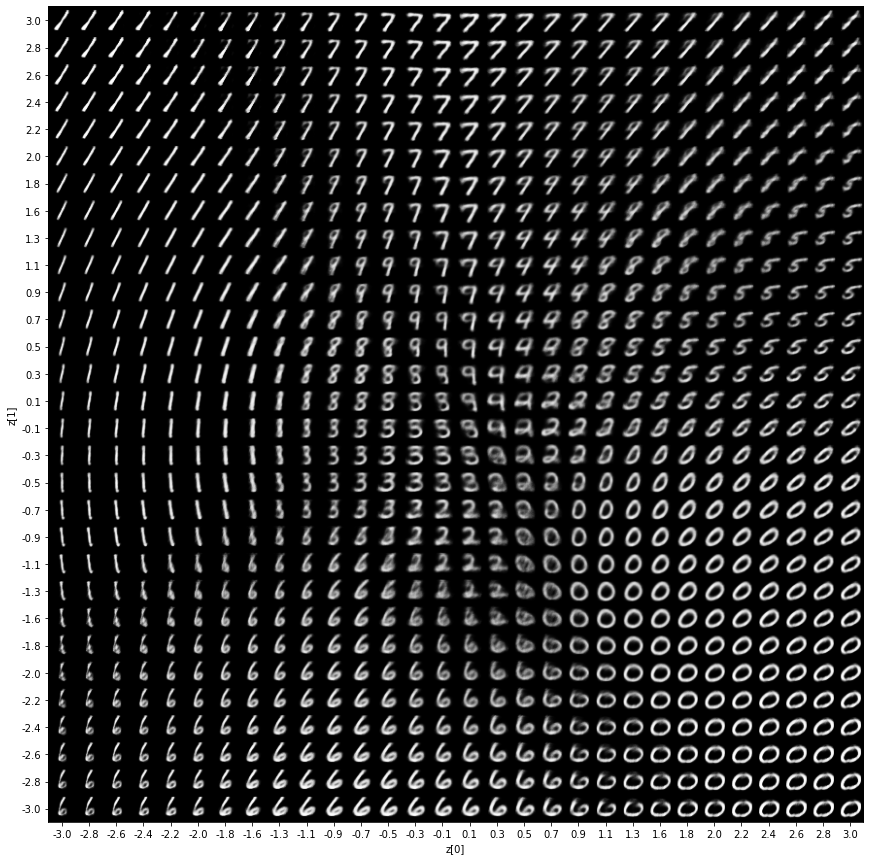

In [27]:
plot_latent(vae)

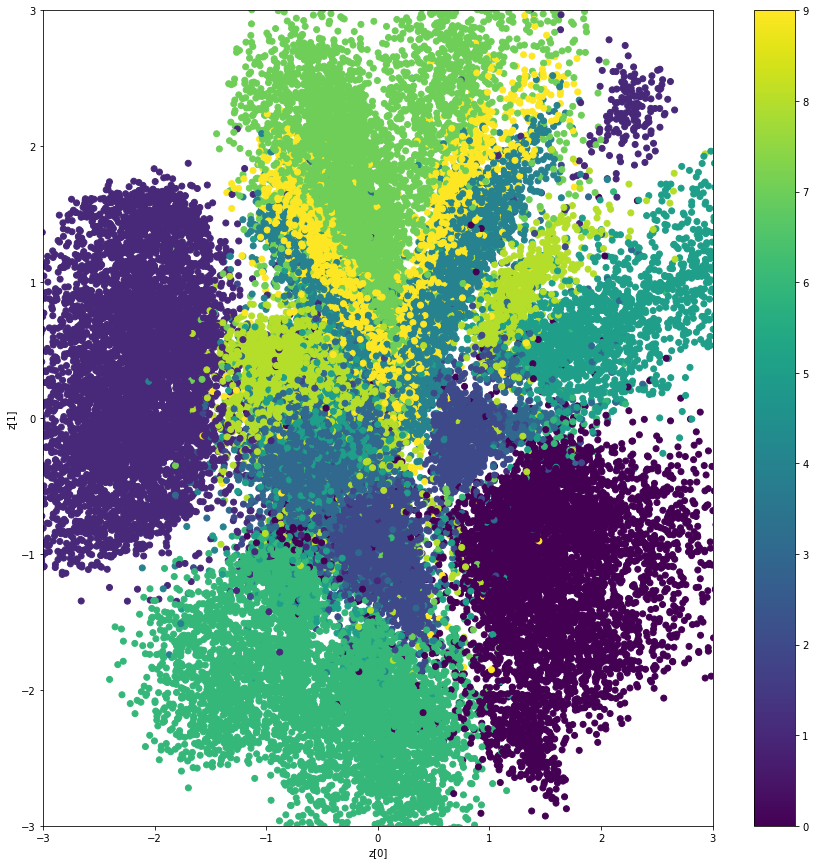

In [28]:
plot_label_clusters(vae, X_train, y_train)